In [5]:
import os

import glob
import fitsio

import numpy as np
import pylab as pl

import desisim.templates
import astropy.io.fits as fits

import desispec.io
import redrock.templates

from   desisim.specsim        import  get_simulator
from   astropy.convolution    import  convolve, Box1DKernel
from   desispec.spectra       import  Spectra
from   desispec.resolution    import  Resolution

from   desispec.interpolation import  resample_flux

from   astropy.table          import  Table

# Foundations to 1004 desispec ticket:  Template SNR and LSS rad. weights.

Template SNR:

https://desi.lbl.gov/DocDB/cgi-bin/private/RetrieveFile?docid=4723;filename=sky-monitor-mc-study-v1.pdf;version=2

In [6]:
#  andes                  = '/global/cfs/cdirs/desi/spectro/redux/andes/'
andes                     = '/global/scratch/mjwilson/desi-data.dm.noao.edu/desi/spectro/redux/andes'

os.environ['SPEC_PROD']   = andes

# os.environ['DESIMODEL'] = '/global/common/software/desi/cori/desiconda/20200801-1.4.0-spec/code/desimodel/0.13.0' 
os.environ['DESIMODEL']   = '/global/scratch/mjwilson/miniconda3/envs/desi/code/desimodel'

# Get a cframe for ELG SV0 tile (67230)

https://desi.lbl.gov/trac/wiki/TargetSelectionWG/SV0

In [7]:
night      = '20200314'

tile       = 67230
petal      = 0

# 0th fiber in the petal.
fiber      = 0

# Get (calibrated) spectra and calibration data 

In [16]:
# For each camera.
frames     = {}
cframes    = {}

psfs       = {}
skies      = {} 

fluxcalibs = {}

for cam in ['g', 'r', 'z']:
  # E.g.  /global/cfs/cdirs/desi/spectro/redux/andes/tiles/67230/20200314/cframe-z9-00055382.fits  
  specpaths    = glob.glob('{}/tiles/{}/{}/cframe-{}{}-*.fits'.format(andes, tile, night, cam, petal))

  expids       = [x.split('-')[-1].replace('.fits', '') for x in specpaths]
        
  # E.g.  /global/cfs/cdirs/desi/spectro/redux/andes/exposures/20200315/00055590/sky-r8-00055590.fits
  # skies_path   = glob.glob('{}/exposures/{}/{}/sky-{}{}-{}.fits'.format(andes, tile, night, cam, petal))
    
  mjd_obs      = 0.0
    
  for i, specpath in enumerate(specpaths):
    dat        = fits.open(specpath)
    
    _          = dat[0].header['MJD-OBS']

    # Get the last in the night, for example.      
    if _ > mjd_obs:          
        cframes[cam]    = fitsio.FITS(specpath)
                
        expid           = expids[i]
        exptime         = dat[0].header['EXPTIME']
        
        fiberid         = cframes[cam]['FIBERMAP']['FIBER'][fiber]
        
        psfs[cam]       = fitsio.FITS('{}/exposures/{}/{}/psf-{}{}-{}.fits'.format(andes, night, expid, cam, petal, expid))
        
        skies[cam]      = fitsio.FITS('{}/exposures/{}/{}/sky-{}{}-{}.fits'.format(andes, night, expid, cam, petal, expid))
        
        # https://desidatamodel.readthedocs.io/en/latest/DESI_SPECTRO_CALIB/fluxcalib-CAMERA.html
        fluxcalibs[cam] = fitsio.FITS('{}/exposures/{}/{}/fluxcalib-{}{}-{}.fits'.format(andes, night, expid, cam, petal, expid))
        
        frames[cam]     = fitsio.FITS('{}/exposures/{}/{}/frame-{}{}-{}.fits'.format(andes, night, expid, cam, petal, expid))
        
        mjd_obs         = dat[0].header['MJD-OBS']

# DESI sim. galaxy spectral templates 

In [17]:
def tracer_maker(wave=None, tracer='ELG', nmodel=1):
    if tracer == 'ELG':
        maker = desisim.templates.ELG(wave=wave)
                
    elif tracer == 'QSO':
        maker = desisim.templates.QSO(wave=wave)
    
    else:
        raise  ValueError('{} is not an available tracer.'.format(tracer))

    flux, wave, meta, objmeta = maker.make_templates(nmodel=nmodel)
        
    return  wave, flux, meta, objmeta     

In [18]:
camera                 = 'z'

In [19]:
wave                   = cframes[camera]['WAVELENGTH'][:]
_, flux, meta, objmeta = tracer_maker(wave=wave, tracer='ELG')

KeyError: 'DESI_BASIS_TEMPLATES'

In [429]:
fflux                  = flux[fiber, :]
flux_ivar              = cframes[camera]['IVAR'][fiber, :]

res                    = cframes[camera]['RESOLUTION'][fiber,:,:]
mask                   = cframes[camera]['MASK'][fiber,:]

fibermap               = desispec.io.empty_fibermap(1) 

In [419]:
gmag = 22.5 - 2.5 * np.log10(meta['FLUX_G'][fiber])
rmag = 22.5 - 2.5 * np.log10(meta['FLUX_R'][fiber])
zmag = 22.5 - 2.5 * np.log10(meta['FLUX_Z'][fiber])

gmag, rmag, zmag

(22.582870488986373, 22.361717643216252, 21.60609744489193)

Text(0, 0.5, 'Observed flux [$10^{-17}$ erg/s/cm2/A)]')

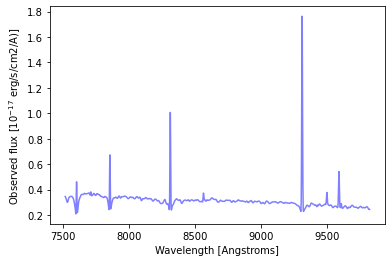

In [420]:
pl.plot(wave, fflux, c='b',    alpha=0.5)

pl.xlabel('Wavelength [Angstroms]')
pl.ylabel('Observed flux [$10^{-17}$ erg/s/cm2/A)]')

Text(0, 0.5, 'Counts per Angstrom')

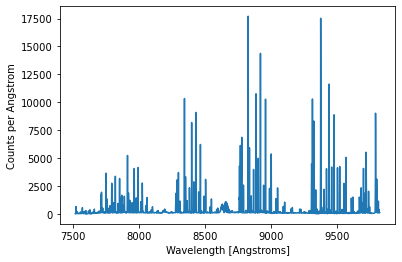

In [421]:
pl.plot(skies[camera]['WAVELENGTH'][:], skies[camera]['SKY'][fiber, :].T)

pl.xlabel('Wavelength [Angstroms]')
pl.ylabel('Counts per Angstrom')

In [422]:
# Includes seeing and airmass terms (therefore fiberloss).
fluxcalib = fluxcalibs[camera]['FLUXCALIB'][fiber,:]

In [423]:
uflux     = fflux * fluxcalib   # Uncalibrated flux [counts/Angstrom] 

## Calculate 'templateSNR' for a DESI spectrum when given a template, an EXPID and a FIBER-TILE-ID.

In [29]:
def templateSNR(template_flux, fluxcalib=None, flux_ivar=None):
    # dlambda per pixel = 0.8; 100A / dlambda per pixel = 125. 
    sflux  = convolve(template_flux, Box1DKernel(125)) 
 
    dflux  = flux - sflux 
 
    if fluxcalib is None:
        # Work in calibrated flux units.
        # Assumes Poisson Variance from source is negligible.
        assert  flux_ivar is not None
        
        return  np.sum((dflux ** 2.) * flux_ivar)

    else: 
        # Work in uncalibrated flux units.
        dflux  *= fluxcalib
 
        result  = dflux * dflux

        # TBD.
        denom   = np.ones_like(result)
        
        result /= denom
        
        # Eqn. (1) of https://desi.lbl.gov/DocDB/cgi-bin/private/RetrieveFile?docid=4723;filename=sky-monitor-mc-study-v1.pdf;version=2
        return  np.sum(result)

In [479]:
FIBERTILEID = 10000 * tile + fiberid

print(tile, expid, fiberid, FIBERTILEID)

67230 00055382 0 672300000


In [480]:
print('Template SNR for the {} band is {}.]'.format(camera, templateSNR(fflux, fluxcalib=None, flux_ivar=flux_ivar)))

Template SNR for the z band is 30.31232313474115.]


##  Post-process spectra post redrock, calculate templateSNR for the redrock best-fit template.

First, run redshift fitting. 

In [384]:
# https://github.com/desihub/desisim/blob/c64ad6c14f36409833ad8616cb8ce180b1af54c1/py/desisim/scripts/quickspectra.py#L248

In [385]:
spec      = Spectra([camera], {camera: wave}, {camera: fflux[None, :]}, {camera: flux_ivar}, 
                     resolution_data={camera : res}, 
                     mask={camera : mask}, 
                     fibermap=fibermap, 
                     meta=None,
                     single=True)

In [386]:
desispec.io.write_spectra('/global/cscratch1/sd/mjwilson/desi/radweights/spec_test.fits', spec)  

'/global/cscratch1/sd/mjwilson/desi/radweights/spec_test.fits'

In [387]:
# https://github.com/desihub/tutorials/blob/master/simulating-desi-spectra.ipynb
zbest_file = os.path.join('/global/cscratch1/sd/mjwilson/desi/radweights/', 'test-zbest.fits')

In [431]:
cmd  = 'rrdesi {} --zbest {}'.format('/global/cscratch1/sd/mjwilson/desi/radweights/spec_test.fits', zbest_file)
srun = 'srun -A desi -N 1 -t 00:10:00 -C haswell --qos interactive'
cmd  = '{} {} --mp 32'.format(srun, cmd)

print(cmd)

srun -A desi -N 1 -t 00:10:00 -C haswell --qos interactive rrdesi /global/cscratch1/sd/mjwilson/desi/radweights/spec_test.fits --zbest /global/cscratch1/sd/mjwilson/desi/radweights/test-zbest.fits --mp 32


Run on Cori Linux.  Finished?  Get the results.

In [481]:
zbest = Table.read(zbest_file, 'ZBEST')

In [482]:
zbest

TARGETID,CHI2,COEFF [10],Z,ZERR,ZWARN,NPIXELS,SPECTYPE,SUBTYPE,NCOEFF,DELTACHI2,NUMEXP,NUMTILE
int64,float64,float64,float64,float64,int64,int64,bytes6,bytes20,int64,float64,int32,int32
0,0.1012810468673706,118.60677429703631 .. 2.1036142971974714,0.9152815456943096,0.00017956067522297597,0,2824,GALAXY,,10,11.341802882030606,0,0


In [483]:
meta['REDSHIFT'][0], zbest['Z'][0]

(0.9152733, 0.9152815456943096)

In [484]:
# Import redrock templates
templates = dict()

for filename in redrock.templates.find_templates():
    t = redrock.templates.Template(filename)
    templates[(t.template_type, t.sub_type)] = t

DEBUG: Read templates from /global/common/software/desi/cori/desiconda/20200801-1.4.0-spec/code/redrock-templates/0.7.2
DEBUG: Using default redshift range -0.0050-1.6997 for rrtemplate-galaxy.fits
DEBUG: Using default redshift range 0.0500-5.9934 for rrtemplate-qso.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-A.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-B.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-CV.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-F.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-G.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-K.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-M.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-WD.fits


In [485]:
rr_z     = zbest['Z'][0]

spectype = zbest['SPECTYPE'][0].strip()
subtype  = zbest['SUBTYPE'][0].strip()

fulltype = (spectype, subtype)
ncoeff   = templates[fulltype].flux.shape[0]
coeff    = zbest['COEFF'][0][0:ncoeff]

In [486]:
rr_z, fulltype

(0.9152815456943096, ('GALAXY', ''))

In [487]:
tflux    = templates[fulltype].flux.T.dot(coeff)
twave    = templates[fulltype].wave * (1. + rr_z)

In [488]:
R        = Resolution(res[0])
txflux   = R.dot(resample_flux(wave, twave, tflux))

Text(0, 0.5, 'Observed flux [$10^{-17}$ erg/s/cm2/A)]')

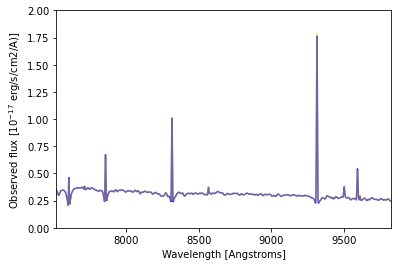

In [489]:
pl.plot(wave, fflux.T,  c='blue', alpha=0.9)
pl.plot(wave, txflux,   c='gold', alpha=0.4)

pl.xlim(wave[0], wave[-1])
pl.ylim(0.0, 2.0)

pl.xlabel('Wavelength [Angstroms]')
pl.ylabel('Observed flux [$10^{-17}$ erg/s/cm2/A)]')

In [490]:
print('Template SNR for the {} band is {}.]'.format(camera, templateSNR(fflux, fluxcalib=None, flux_ivar=flux_ivar)))

Template SNR for the z band is 30.31232313474115.]


In [491]:
print('RRTemplate SNR for the {} band is {}.]'.format(camera, templateSNR(txflux, fluxcalib=None, flux_ivar=flux_ivar)))

RRTemplate SNR for the z band is 30.28025238859542.]


In [492]:
dChi2         = zbest['DELTACHI2']

templatesnr   = templateSNR(fflux, fluxcalib=None, flux_ivar=flux_ivar)
rrtemplatesnr = templateSNR(txflux, fluxcalib=None, flux_ivar=flux_ivar)

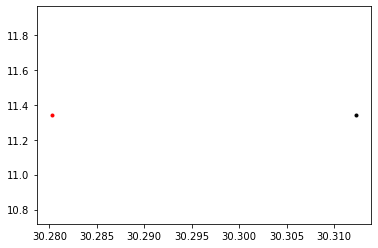

In [493]:
pl.plot(templatesnr,   dChi2, marker='.', c='k')
pl.plot(rrtemplatesnr, dChi2, marker='.', c='r')

##  Rad. weights

_Each tile, each fiber, a redshift efficiency as a function of redshift and target magnitude, per target class. This could be
for instance in the form of fits images in 3D (fiber x redshift x magnitude), with one HDU per target class, and one fits
file per tile_

In [511]:
hdr             = fits.open(specpath)[0].header

hdr['EXTNAME']  = 'RADWEIGHT'

primary         = fits.PrimaryHDU(header=hdr)

# LRG
lrg_radweight   = fits.ImageHDU(np.zeros((1, 25, 25)), name='LRG')

# ELG
elg_radweight   = fits.ImageHDU(np.zeros((1, 25, 25)), name='ELG')

# QSO
qso_radweight   = fits.ImageHDU(np.zeros((1, 25, 25)), name='QSO')

# List
all_hdus        = fits.HDUList([primary, lrg_radweight, elg_radweight, qso_radweight])

all_hdus.writeto('/global/cscratch1/sd/mjwilson/desi/radweights/lss_radweights.fits', overwrite=True)

In [512]:
hdr

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -32 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                 2881                                                  
NAXIS2  =                  500                                                  
EXTEND  =                    T                                                  
EXTNAME = 'RADWEIGHT'                                                           
OBSERVAT= 'KPNO    '           / Observatory name                               
OBS-LAT = '31.96403'           / [deg] Observatory latitude                     
OBS-LONG= '-111.59989'         / [deg] Observatory east longitude               
OBS-ELEV=                2097. / [m] Observatory elevation                      
TELESCOP= 'KPNO 4.0-m telescope' / Telescope name                               
INSTRUME= 'DESI    '        

# 2D PSF and NPIX

Expectation of 3.44 for PSF size in pixel units (spectro paper).

In [30]:
import fitsio
import astropy.io.fits as fits
import numpy as np

from   specter.psf import PSF
from   specter.psf.gausshermite import GaussHermitePSF

In [31]:
fname = '/global/scratch/mjwilson/desi-data.dm.noao.edu/desi/spectro/redux/andes/calibnight/20200314/psfnight-b0-20200314.fits'

In [32]:
psf = GaussHermitePSF(fname)

In [33]:
# One petal, one arm to a CCD.
psf.nspec, psf.npix_x, psf.npix_y

(500, 4096, 4096)

In [34]:
fiber = 250
wave  = 5000.

In [35]:
# https://github.com/desihub/specter/blob/f242a3d707c4cba549030af6df8cf5bb12e2b47c/py/specter/psf/psf.py#L467
x,y= psf.xy(fiber, wave)
x,y

(2046.4178332968274, 2362.301078211112)

In [36]:
# https://github.com/desihub/specter/blob/f242a3d707c4cba549030af6df8cf5bb12e2b47c/py/specter/psf/psf.py#L300
# Returns:  (xmin, xmax, ymin, ymax)
psf.xyrange(fiber, wave)

(2038, 2055, 2357, 2368)

In [37]:
# Return Gaussian sigma of PSF spot in cross-dispersion direction in CCD pixel units.
#  Gaussian PSF, radius R that maximizes S/N for a faint source in the sky-limited case is 1.7σ
#  http://www.ucolick.org/~bolte/AY257/s_n.pdf
2. * 1.7 * psf.xsigma(ispec=fiber, wavelength=wave)

3.3812719406152274

In [38]:
#  Gaussian sigma of PSF spot in dispersion direction in CCD pixel units.
#  Gaussian PSF, radius R that maximizes S/N for a faint source in the sky-limited case is 1.7σ
#  http://www.ucolick.org/~bolte/AY257/s_n.pdf
2. * 1.7 * psf.ysigma(ispec=fiber, wavelength=wave)

3.688567382805907

In [39]:
psf_2d = psf.pix(ispec=fiber, wavelength=wave)

In [40]:
psf_2d.shape

(11, 17)

In [41]:
norm = np.sum(psf_2d); norm

1.0000000000000002

In [42]:
# http://articles.adsabs.harvard.edu/pdf/1983PASP...95..163K
NEA = 1. / np.sum(psf_2d ** 2.) # [pixel units].
NEA

16.05356694521429

In [43]:
psf.angstroms_per_pixel(fiber, wave)

0.5918649065496242

# Read noise

In [16]:
from desispec.io.image import read_image

In [17]:
image = read_image('/global/scratch/mjwilson/desi-data.dm.noao.edu/desi/spectro/redux/andes/preproc/20200314/00055353/preproc-b0-00055353.fits')

In [18]:
image.camera

'b0'

In [19]:
# electrons/pixel (float).
image.readnoise 

array([[4.11365318, 4.11365318, 4.11365318, ..., 3.34183311, 3.34183311,
        3.34183311],
       [4.11365318, 4.11365318, 4.11365318, ..., 3.34183311, 3.34183311,
        3.34183311],
       [4.11365318, 4.11365318, 4.11365318, ..., 3.34183311, 3.34183311,
        3.34183311],
       ...,
       [3.69769478, 3.69769478, 3.69769478, ..., 4.20215082, 4.20215082,
        4.20215082],
       [3.69769478, 3.69769478, 3.69769478, ..., 4.20215082, 4.20215082,
        4.20215082],
       [3.69769478, 3.69769478, 3.69769478, ..., 4.20215082, 4.20215082,
        4.20215082]])

In [20]:
(xmin, xmax, ymin, ymax) = psf.xyrange(fiber, wave)

In [21]:
# Why is this reversed?  Note:  Shape should match psf cutout generated above.
rd_cutout = image.readnoise[ymin:ymax, xmin:xmax]

In [22]:
rd_cutout.shape

(11, 17)

In [26]:
# electrons/pixel
np.median(rd_cutout)

3.7316248416900635

In [27]:
np.median(image.readnoise)

3.915674328804016

# Fiberloss correction on flux calibration vector

In [28]:
# https://github.com/desihub/desispec/blob/6c9810df3929b8518d49bad14356d35137d25a89/py/desispec/fluxcalibration.py#L809

In [ ]:
from desimodel.io import load_desiparams, load_fiberpos, load_platescale, load_tiles, load_deviceloc

In [62]:
def fiber_area_arcsec2(x, y):
  params       = load_desiparams()

  fiber_dia    = params['fibers']['diameter_um']
    
  x            = np.asarray(x)
  y            = np.asarray(y)

  r            = np.sqrt(x**2 + y**2)

  #- Platescales in um/arcsec
  ps           = load_platescale()

  # ps['radius'] in mm.
  radial_scale = np.interp(r, ps['radius'], ps['radial_platescale'])
  az_scale     = np.interp(r, ps['radius'], ps['az_platescale'])
 
  #- radial and azimuthal fiber radii in arcsec
  rr           = 0.5 * fiber_dia / radial_scale
  raz          = 0.5 * fiber_dia / az_scale

  fiber_area = (np.pi * rr * raz)

  return rr, raz, fiber_area 

In [64]:
fiber_area_arcsec2(0.0, 0.0)

(0.7927738217452752, 0.7927738209229515, 1.9744606092121348)

In [66]:
def moffatt(r, fwhm, beta=3.5):
  ##  Apparent radial profile of star-light due to buffeting by the atmosphere.  
  ##  Sec. 4 of https://iopscience.iop.org/article/10.1086/675808/pdf;  [arcsecond].                                                                                                                                                         
  alpha    = fwhm / 2. / (2.**(1./beta) - 1.)**0.5

  return  (2. * (beta - 1.) / alpha / alpha) * (1. + (r/alpha)**2.)**-beta

In [67]:
fwhm       = 2.0
dr         = 0.01

rs         = np.arange(0.0, 15., dr)  ## [arcseconds].        
ms         = moffatt(rs, fwhm)

In [68]:
theta      = 0.7927738217452752

(-0.1, 6.0)

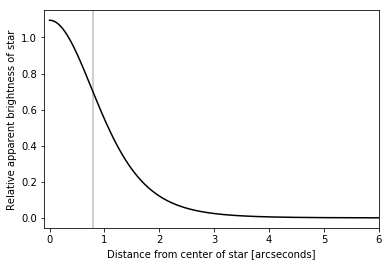

In [69]:
pl.axvline(theta, alpha=0.25, c='k')

pl.plot(rs, ms, c='k')
pl.xlabel('Distance from center of star [arcseconds]')
pl.ylabel('Relative apparent brightness of star')
pl.xlim(left=-0.1, right=6.0)

In [36]:
# A range of full-width @ half max. values for the seeing.  
fwhms      = np.arange(0.5, 3.5, 0.1)

# Find the index in our distance grid closest to the size of a fiber. 
indx       = np.abs(rs - theta).argmin()

# A list to collect the fraction of light down a fiber for each value of the seeing. 
fiberfracs = []

# Loop over the seeing values. 
for i, fwhm in enumerate(fwhms):
  # Work out the radial profile of the star.
  ms       = moffatt(rs, fwhm)
  
  # Integrate this to get the total light within a radius
  Is       = 2. * np.pi * dr * np.cumsum(rs * ms)

  # Calculate the fiber fraction for each r value we as for. 
  ffrac    = Is / Is[-1]
  
  # Save the fiber fraction for the radius corresponding to the fiber size. 
  fiberfracs.append(ffrac[indx])

fiberfracs = np.array(fiberfracs)

pl.plot(fwhms, fiberfracs)

pl.xlim(0.5, 3.0)

pl.xlabel(r'$(FWHM) \ Seeing \ [{\rm arcseconds}]$')
pl.ylabel(r'FIBER FRAC.')

NameError: name 'rs' is not defined

In [37]:
gfa = Table.read('/global/scratch/mjwilson/offline_all_guide_ccds_SV0.fits')

In [38]:
gfa = gfa[gfa['SPECTRO_EXPID'] > -1]
gfa = gfa[gfa['N_SOURCES_FOR_PSF'] > 2]
gfa = gfa[gfa['CONTRAST'] > 2]
gfa = gfa[gfa['NPIX_BAD_TOTAL'] < 10]

gfa.sort('SPECTRO_EXPID')

In [42]:
gfa = gfa['SPECTRO_EXPID', 'FWHM_ASEC', 'TRANSPARENCY', 'FIBER_FRACFLUX', 'SKY_MAG_AB', 'MJD']

In [43]:
by_spectro_expid = gfa.group_by('SPECTRO_EXPID')

In [44]:
print(by_spectro_expid)

SPECTRO_EXPID     FWHM_ASEC      ...     SKY_MAG_AB          MJD      
------------- ------------------ ... ------------------ --------------
        55353 1.3730546045303345 ...  20.02242224764418 58923.10557146
        55353 1.6560531616210936 ... 20.115695049015358 58923.10615198
        55353 1.4049282789230346 ...  20.14162118293241 58923.10615198
        55353  1.629009003639221 ... 20.074148289939522 58923.10615198
        55353 1.3527715349197387 ... 20.129678733922994 58923.10603455
        55353 1.3015805768966675 ... 20.184998987666543 58923.10603455
        55353 1.5053782320022582 ... 20.132503205381056 58923.10603455
        55353 1.3247613954544066 ... 20.160465024690833 58923.10603454
        55353 1.5324223899841307 ...  20.13698461481178 58923.10603454
        55353 1.3585666418075562 ... 20.131490671695843 58923.10591878
          ...                ... ...                ...            ...
        55692 1.3295907163619993 ... 20.327295808488497 58924.51941831
      

In [47]:
gfa_mean   = by_spectro_expid.groups.aggregate(np.mean)
gfa_median = by_spectro_expid.groups.aggregate(np.median)

In [48]:
gfa_median

SPECTRO_EXPID,FWHM_ASEC,TRANSPARENCY,FIBER_FRACFLUX,SKY_MAG_AB,MJD
int32,float64,float64,float64,float64,float64
55353,1.3556690883636473,0.9491531856658579,0.42902994928339766,20.13257532857953,58923.105804845
55354,1.0842609405517578,0.9306584084094406,0.5758220848678852,20.716475970074487,58923.11684792
55355,1.1528374147415161,0.9287752724595781,0.5266150665431396,20.751343417592672,58923.12406566
55356,1.124827275276184,0.9291547576080916,0.5513398270660941,20.78339337676281,58923.1282444
55357,1.1412470054626465,0.9324662058076588,0.5494354959155627,20.736887796902987,58923.13247917
55358,1.0398310708999634,0.926993168397129,0.6079540155317155,20.732981448479244,58923.13667283
55359,1.3305566978454588,0.8911601509977743,0.42628248906121285,20.784752835872254,58923.14101085
55360,1.248458046913147,0.9177696043867326,0.47084553982027816,20.80443171895309,58923.14525603
55361,1.1383494520187378,0.8861931873134048,0.5298523127713594,20.773264489657137,58923.14950753


## Done.